🟢 EDA BEFORE PREPROCESSING

Shape: (200, 8)

Data Types:
 Claim_ID             object
Claim_Date           object
Customer_ID          object
Claim_Amount        float64
Claim_Type           object
Suspicious_Flags      int64
Fraud_Label           int64
Annual_Income         int64
dtype: object

Missing Values:
 Claim_ID            0
Claim_Date          0
Customer_ID         0
Claim_Amount        0
Claim_Type          0
Suspicious_Flags    0
Fraud_Label         0
Annual_Income       0
dtype: int64


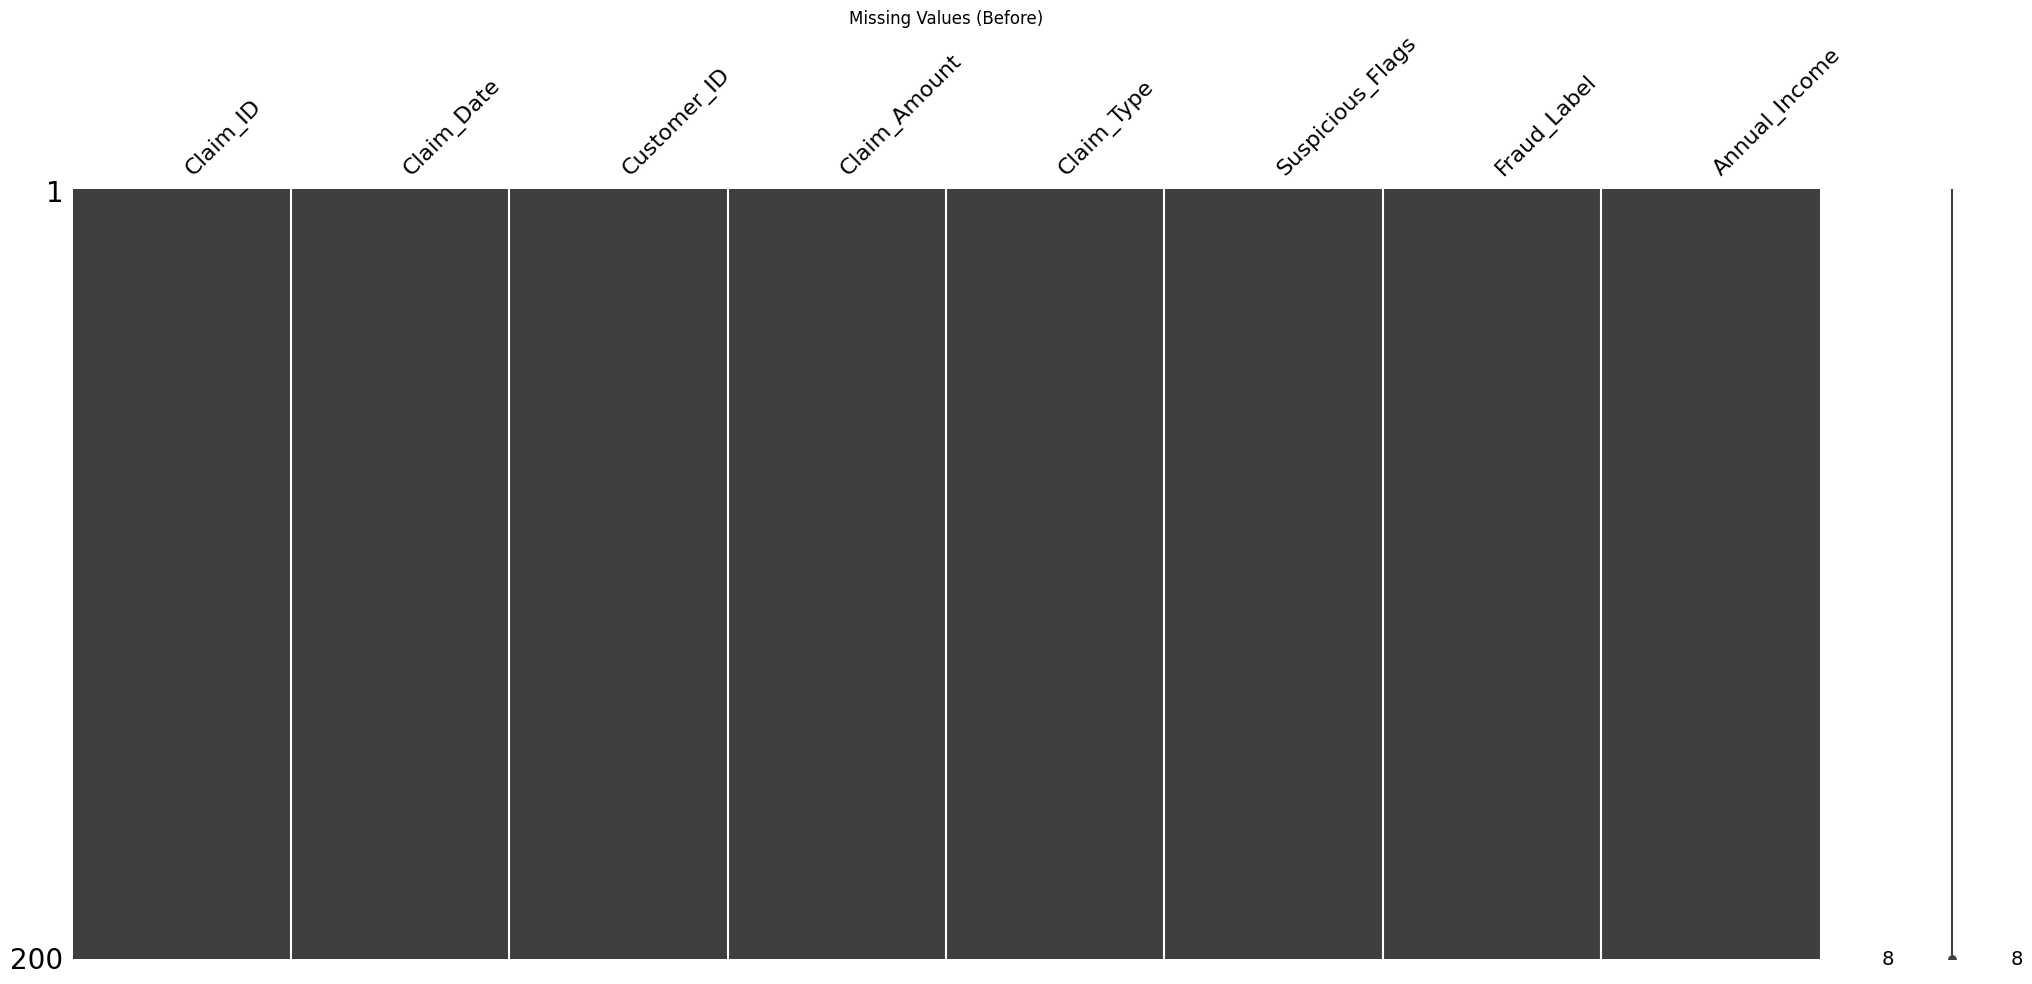

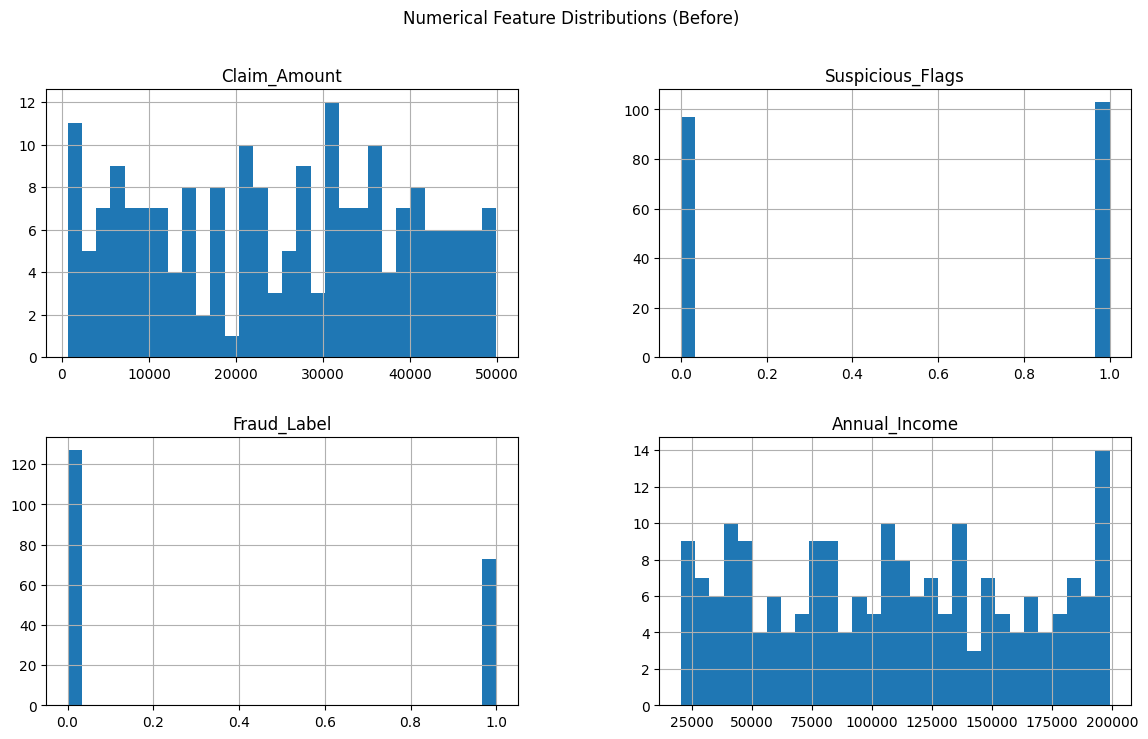

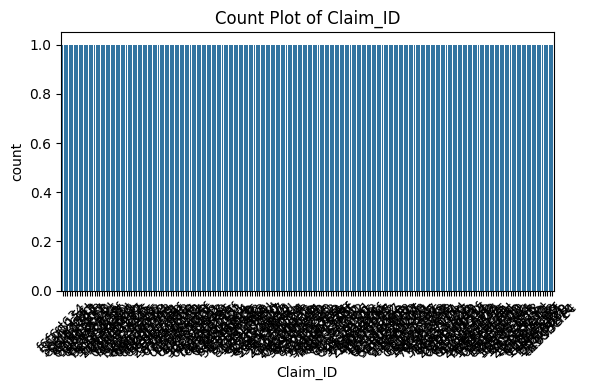

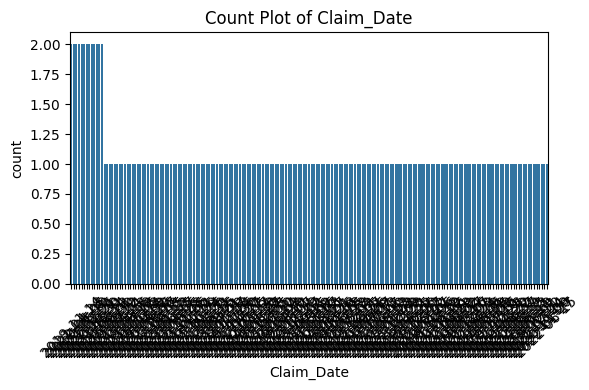

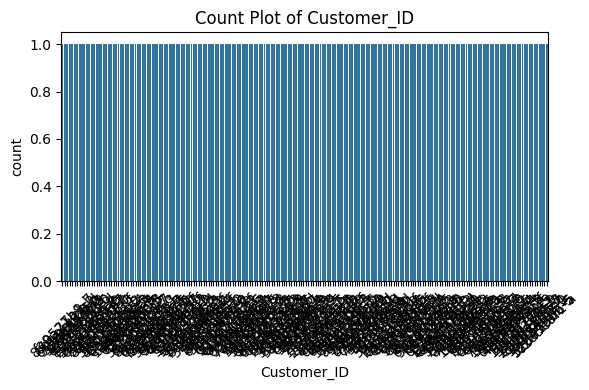

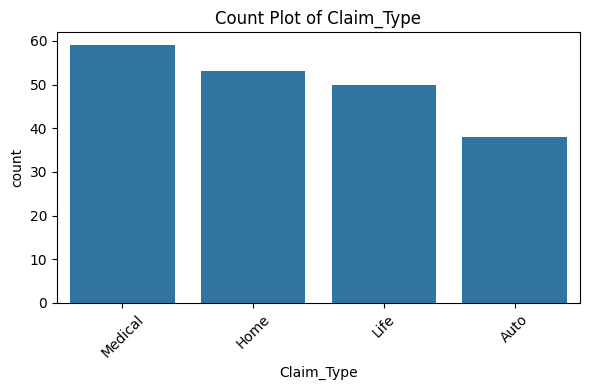


🛠️ PREPROCESSING...

✅ Preprocessing Complete
New Shape: (200, 8)

🟢 EDA AFTER PREPROCESSING

Missing Values After: 0


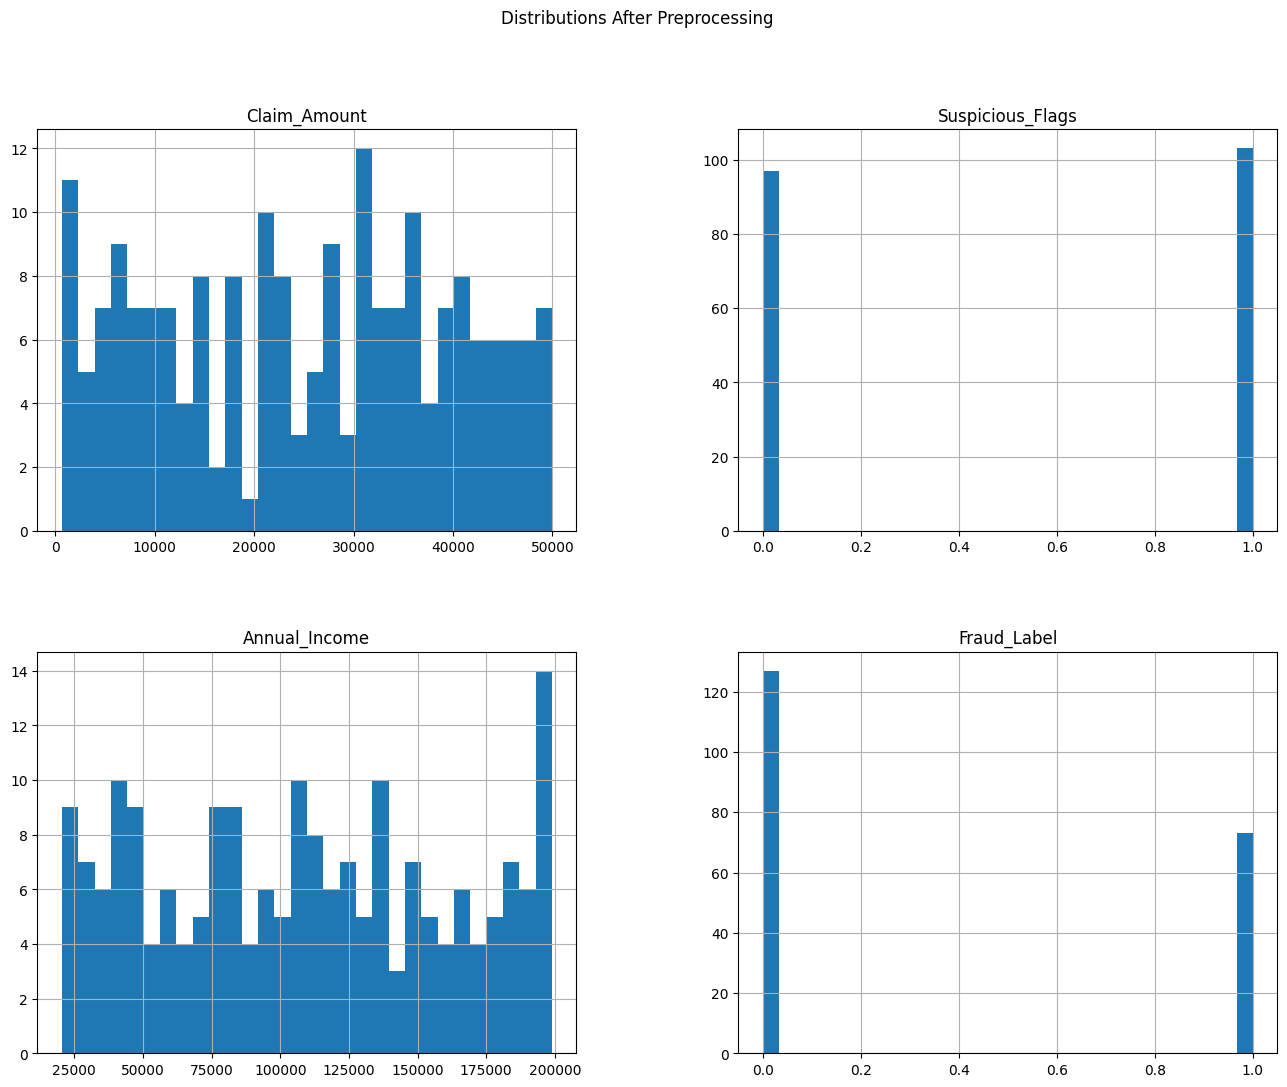

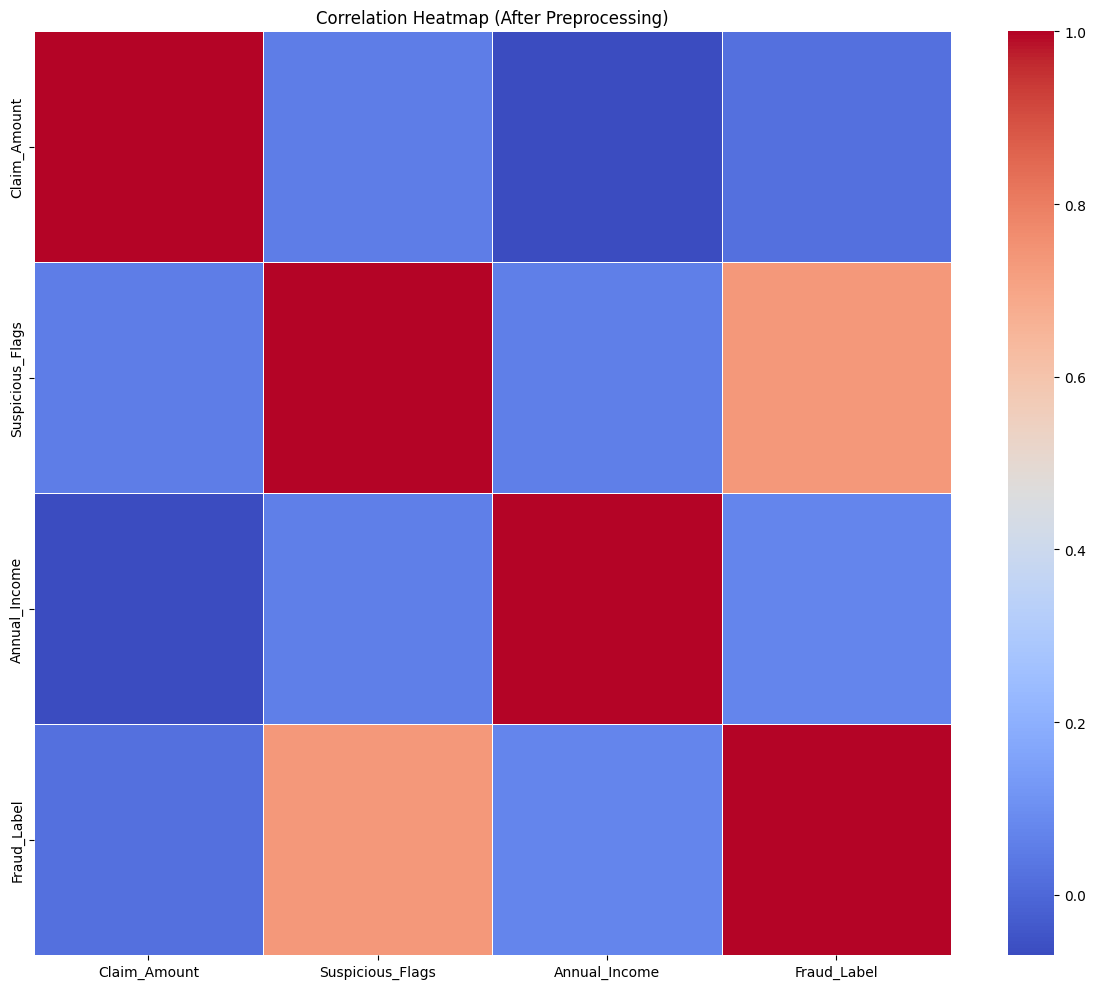


Summary Stats:


,Claim_Date,Claim_Amount,Suspicious_Flags,Annual_Income,Fraud_Label
count,200,200.000000,200.000000,200.000000,200.000000
mean,2021-08-11 08:16:48,25053.198000,0.515000,108588.980000,0.365000
min,2019-01-10 00:00:00,647.830000,0.000000,20446.000000,0.000000
25%,2020-06-11 00:00:00,11443.802500,0.000000,61109.250000,0.000000
50%,2021-07-30 12:00:00,26346.345000,1.000000,108796.000000,0.000000
75%,2022-08-24 18:00:00,36673.765000,1.000000,152735.250000,1.000000
max,2024-03-15 00:00:00,49951.330000,1.000000,198940.000000,1.000000
std,NaN,14570.754503,0.501029,53850.502961,0.482638



Data Types After Preprocessing:
Claim_Date            datetime64[ns]
Claim_Amount                 float64
Suspicious_Flags               int64
Annual_Income                  int64
Claim_Type_Home                 bool
Claim_Type_Life                 bool
Claim_Type_Medical              bool
Fraud_Label                    int64
dtype: object


In [7]:
# 📦 Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder

# ✅ Define the EDA + Preprocessing Function
def run_eda_pipeline(df, target_column=None, encode_method='onehot', drop_first=True):
    df = df.copy()

    # Validate target column
    if target_column and target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in DataFrame. Available columns: {df.columns.tolist()}")

    print("🟢 EDA BEFORE PREPROCESSING\n")
    print("Shape:", df.shape)
    print("\nData Types:\n", df.dtypes)
    print("\nMissing Values:\n", df.isnull().sum())

    # Missing values plot
    msno.matrix(df)
    plt.title("Missing Values (Before)")
    plt.show()

    # Histograms for numeric features
    num_cols = df.select_dtypes(include=np.number).columns.tolist()
    df[num_cols].hist(figsize=(14, 8), bins=30)
    plt.suptitle("Numerical Feature Distributions (Before)")
    plt.show()

    # Count plots for categorical features (excluding target)
    cat_cols = df.select_dtypes(include='object').columns.tolist()
    if target_column and target_column in cat_cols:
        cat_cols.remove(target_column)

    for col in cat_cols:
        plt.figure(figsize=(6, 4))
        sns.countplot(data=df, x=col, order=df[col].value_counts().index)
        plt.title(f"Count Plot of {col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # -------------------------
    # 🧹 Preprocessing
    # -------------------------
    print("\n🛠️ PREPROCESSING...\n")
    df.drop_duplicates(inplace=True)

    # Separate target column
    df_features = df.drop(columns=[target_column]) if target_column else df.copy()
    target_series = df[target_column] if target_column else None

    # Convert Claim_Date to datetime
    if 'Claim_Date' in df_features.columns:
        df_features['Claim_Date'] = pd.to_datetime(df_features['Claim_Date'], errors='coerce')

    # Drop ID columns if they exist
    id_columns = ['Claim_ID', 'Customer_ID']
    df_features.drop(columns=[col for col in id_columns if col in df_features.columns], inplace=True)

    # Fill missing values
    df_features.fillna(df_features.median(numeric_only=True), inplace=True)
    df_features.fillna(df_features.mode().iloc[0], inplace=True)

    # Encode categorical features
    if encode_method == 'onehot':
        df_encoded = pd.get_dummies(df_features, drop_first=drop_first)
    elif encode_method == 'label':
        label_enc = LabelEncoder()
        for col in df_features.select_dtypes(include='object').columns:
            df_features[col] = label_enc.fit_transform(df_features[col])
        df_encoded = df_features
    else:
        raise ValueError("encode_method must be 'onehot' or 'label'")

    # Combine with target again
    if target_column:
        df_processed = pd.concat([df_encoded, target_series], axis=1)
    else:
        df_processed = df_encoded

    print("✅ Preprocessing Complete")
    print("New Shape:", df_processed.shape)

    # -------------------------
    # EDA After Preprocessing
    # -------------------------
    print("\n🟢 EDA AFTER PREPROCESSING\n")
    print("Missing Values After:", df_processed.isnull().sum().sum())

    # Histograms after preprocessing
    df_processed.select_dtypes(include=np.number).hist(figsize=(16, 12), bins=30)
    plt.suptitle("Distributions After Preprocessing")
    plt.show()

    # Correlation heatmap
    corr_df = df_processed.select_dtypes(include=np.number)
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_df.corr(), cmap="coolwarm", linewidths=0.5)
    plt.title("Correlation Heatmap (After Preprocessing)")
    plt.tight_layout()
    plt.show()

    print("\nSummary Stats:")
    display(df_processed.describe())

    # ✅ Data types after preprocessing
    print("\nData Types After Preprocessing:")
    print(df_processed.dtypes)

    return df_processed

df = pd.read_csv("C:/Users/Administrator/fraudulent_claims_dataset.csv")
processed_df = run_eda_pipeline(df, target_column='Fraud_Label', encode_method='onehot')


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import pickle

# Load dataset
df = pd.read_csv("C:/Users/Administrator/fraudulent_claims_dataset.csv")

# Convert Claim_Date to datetime and extract useful features
df["Claim_Date"] = pd.to_datetime(df["Claim_Date"], errors='coerce')
df["Claim_Month"] = df["Claim_Date"].dt.month
df["Claim_Day"] = df["Claim_Date"].dt.day
df.drop("Claim_Date", axis=1, inplace=True)

# Remove ID columns that shouldn't be features
df = df.drop(columns=["Claim_ID", "Customer_ID"])

# Handle missing values
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Encode categorical variables
categorical_cols = ["Claim_Type", "Suspicious_Flags"]
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Normalize numerical features
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Define features and target
X = df.drop(columns=["Fraud_Label"])
y = df["Fraud_Label"]

# Handle class imbalance
smote = SMOTE(sampling_strategy=0.75, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, 
                                                   test_size=0.2, random_state=42)

# Train and save Random Forest model
best_model = RandomForestClassifier(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)

# Save model and preprocessing artifacts
with open("C:/Users/Administrator/Fraudulent_Detection_Model.pkl", "wb") as file:
    pickle.dump({
        'model': best_model,
        'scaler': scaler,
        'label_encoder': le,
        'feature_names': X.columns.tolist()
    }, file)

# Evaluate performance
y_pred = best_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")

Accuracy: 0.93
Precision: 0.89
Recall: 0.94
F1 Score: 0.91


=== Model Performance ===
Accuracy: 0.91
Precision: 0.84
Recall: 0.94
F1 Score: 0.89
ROC AUC: 0.94

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.89      0.93        28
         1.0       0.84      0.94      0.89        17

    accuracy                           0.91        45
   macro avg       0.90      0.92      0.91        45
weighted avg       0.92      0.91      0.91        45



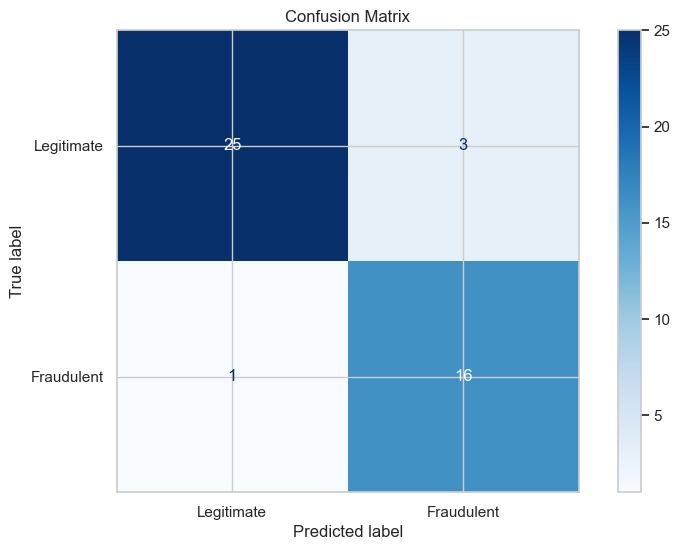

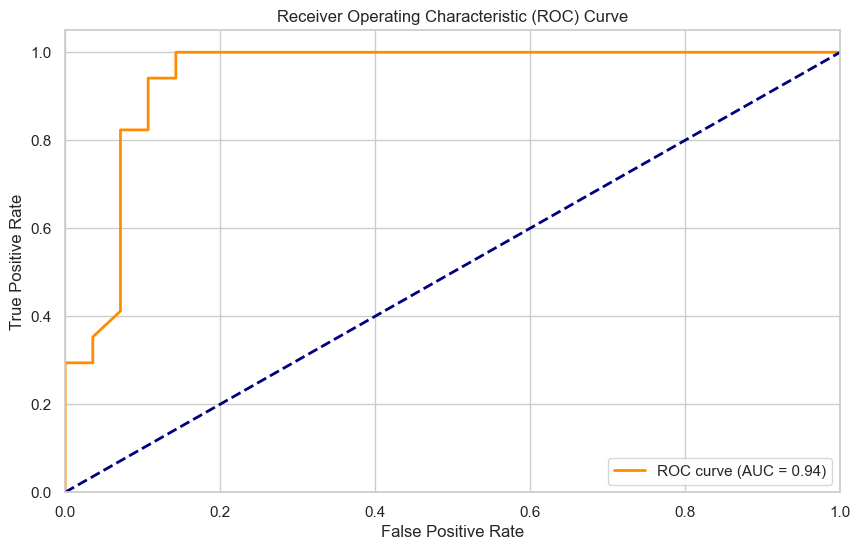

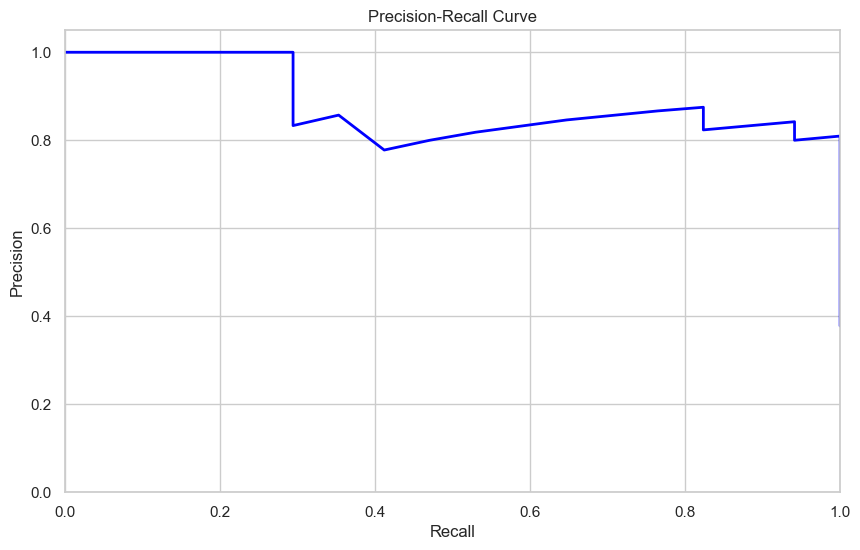

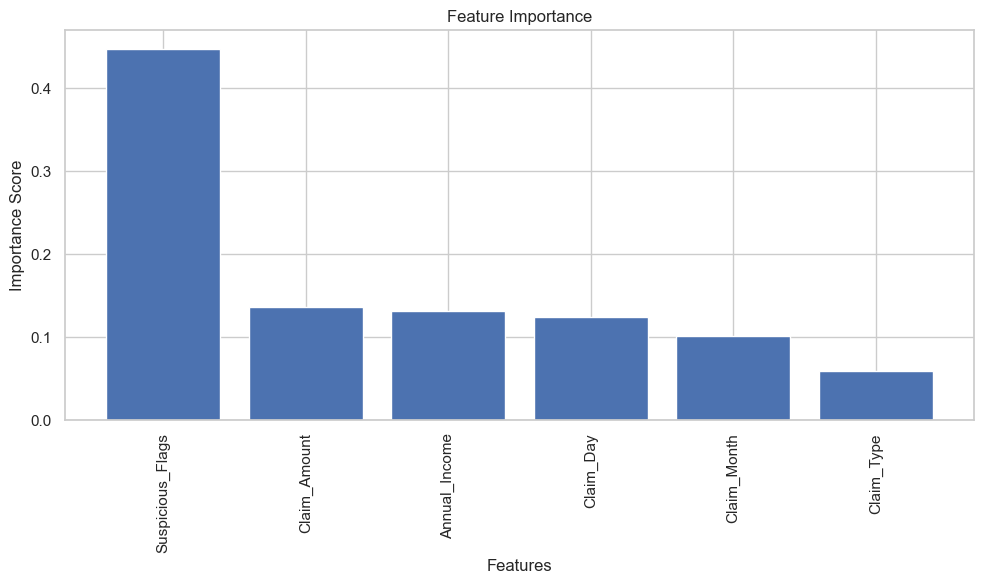

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve, auc, 
                             precision_recall_curve, classification_report)
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings("ignore")

# Set plot style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

def load_and_preprocess_data(filepath):
    """Load and preprocess the dataset"""
    # Load data
    df = pd.read_csv(filepath)
    
    # Feature engineering from date
    df["Claim_Date"] = pd.to_datetime(df["Claim_Date"], errors='coerce')
    df["Claim_Month"] = df["Claim_Date"].dt.month
    df["Claim_Day"] = df["Claim_Date"].dt.day
    df.drop("Claim_Date", axis=1, inplace=True)
    
    # Remove non-predictive columns
    df = df.drop(columns=["Claim_ID", "Customer_ID"])
    
    # Handle missing values
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
    
    # Encode categorical variables
    categorical_cols = ["Claim_Type", "Suspicious_Flags"]
    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])
    
    return df, le

def preprocess_features(df, le):
    """Preprocess features and split data"""
    # Normalize numerical features
    scaler = MinMaxScaler()
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    
    # Split features and target
    X = df.drop(columns=["Fraud_Label"])
    y = df["Fraud_Label"]
    
    return X, y, scaler

def plot_confusion_matrix(y_true, y_pred):
    """Plot enhanced confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=['Legitimate', 'Fraudulent'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

def plot_roc_curve(y_true, y_proba):
    """Plot ROC curve with AUC score"""
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(y_true, y_proba):
    """Plot precision-recall curve"""
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    
    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.show()

def plot_feature_importance(model, feature_names):
    """Plot feature importance"""
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]
    
    plt.figure()
    plt.title("Feature Importance")
    plt.bar(range(len(importance)), importance[indices], align="center")
    plt.xticks(range(len(importance)), [feature_names[i] for i in indices], rotation=90)
    plt.xlabel("Features")
    plt.ylabel("Importance Score")
    plt.tight_layout()
    plt.show()

def main():
    # Load and preprocess data
    df, le = load_and_preprocess_data("C:/Users/Administrator/fraudulent_claims_dataset.csv")
    X, y, scaler = preprocess_features(df, le)
    
    # Handle class imbalance
    smote = SMOTE(sampling_strategy=0.75, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.2, random_state=42
    )
    
    # Train model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Save model artifacts
    with open("Fraudulent_Detection_Model.pkl", "wb") as f:
        pickle.dump({
            'model': model,
            'scaler': scaler,
            'label_encoder': le,
            'feature_names': X.columns.tolist()
        }, f)
    
    # Print metrics
    print("=== Model Performance ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Generate plots
    plot_confusion_matrix(y_test, y_pred)
    plot_roc_curve(y_test, y_proba)
    plot_precision_recall_curve(y_test, y_proba)
    plot_feature_importance(model, X.columns)

if __name__ == "__main__":
    main()